In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Baseline GNN Training

Here, I train a basic GNN with node features, not including target information or mean encoded target information.  Nodes are businesses or NAICS, with edges to the exact match NAICS or same-sector NAICS.

Batching is used for training, and nodes are sampled at each layer.  I use a 2-layer GNN

Refs
  * https://www.tensorflow.org/guide/keras/serialization_and_saving
  * http://stellargraph.readthedocs.io/en/v1.2.0/api.html
  * https://github.com/tensorflow/tensorflow/issues/46659
  * https://stackoverflow.com/questions/59493222/access-output-of-intermediate-layers-in-tensor-flow-2-0-in-eager-mode

*This script takes about 2 hours on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
import importlib
import pickle

In [4]:
import stellargraph as sg
from stellargraph.layer import HinSAGE
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import keras
import tensorflow.keras.metrics as km
from keras import initializers
import tensorflow as tf

2023-12-19 06:29:28.466673: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-19 06:29:28.466698: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-19 06:29:28.466703: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-19 06:29:28.466902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-19 06:29:28.466922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Import Data
Import Stellargraph dataset for training

##### Heterogeneous graph

In [5]:
# Training and validation clients - monitor training on val clients
with open(Path(setup.temp_path).joinpath('11_DATA_stellargraph_train_val.pkl'), 'rb') as fin:
      sba_graph  = pickle.load(fin)

In [6]:
print(sba_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 544895, Edges: 54210785

 Node types:
  LoanNr_ChkDgt: [543584]
    Features: float32 vector, length 10
    Edge types: LoanNr_ChkDgt-loan_naics->NAICS, LoanNr_ChkDgt-loan_sector_naics->NAICS
  NAICS: [1311]
    Features: float32 vector, length 9
    Edge types: NAICS-loan_naics->LoanNr_ChkDgt, NAICS-loan_sector_naics->LoanNr_ChkDgt

 Edge types:
    LoanNr_ChkDgt-loan_sector_naics->NAICS: [53667201]
        Weights: all 1 (default)
        Features: none
    LoanNr_ChkDgt-loan_naics->NAICS: [543584]
        Weights: all 1 (default)
        Features: none


##### Labels

In [7]:
label_data = pd.read_parquet(Path(setup.temp_path).joinpath('11_DATA_labels_train_val.parquet'))

## Process labels
Get separate train, test label dataframes.  Also get initial target rate (for metric tracking)

In [8]:
train_labels = label_data[label_data['dset'] == 'train'].drop(columns=['dset']).set_index('LoanNr_ChkDgt')
val_labels = label_data[label_data['dset'] == 'val'].drop(columns=['dset']).set_index('LoanNr_ChkDgt')
print(f'this graph labels shape {label_data.shape}')
print(f'train labels shape {train_labels.shape}')
print(f'validation labels shape {val_labels.shape}')

this graph labels shape (543584, 4)
train labels shape (447252, 2)
validation labels shape (96332, 2)


In [9]:
vc = train_labels['target'].value_counts(normalize=True)
base_thresh = vc.loc[1]
print(f'target rate: {base_thresh}')

target rate: 0.20301083058320588


## Train

##### Set seeds to setup

In [10]:
# Set some seeds
np.random.seed(16)
tf.random.set_seed(16)
sg.random.set_seed(4345)

##### Node Predictor Generator and "Flows"
Create objects to train on train cases, monitor on validation cases

In [11]:
generator = HinSAGENodeGenerator(sba_graph, batch_size=20, 
                                 num_samples=[10, 20], 
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=2454)

In [12]:
train_gen = generator.flow(train_labels.index, train_labels['target'], shuffle=True)

In [13]:
val_gen = generator.flow(val_labels.index, val_labels['target'], shuffle=False)

##### Create HinSage model (a Keras model)

In [14]:
graphsage_model = HinSAGE(
    layer_sizes=[8, 8], generator=generator, bias=True, dropout=0.5,
)

In [15]:
tf.random.set_seed(16)
keras.utils.set_random_seed(812)
sg.random.set_seed(4345)

In [16]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=1, activation="sigmoid",
                         kernel_initializer=initializers.glorot_uniform(seed=676))(x_out) 

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [18]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss = losses.binary_crossentropy,  
    metrics=["acc", km.AUC(curve='PR'), km.Precision(thresholds=base_thresh), 
             km.Recall(thresholds=base_thresh)],
)

##### Fit model

In [19]:
history = model.fit(
    train_gen, epochs=20, validation_data=val_gen, verbose=2, shuffle=True
)

Epoch 1/20


2023-12-19 06:31:47.277069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-19 07:16:51.977233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5591/5591 - 2896s - loss: 0.5307 - acc: 0.7786 - auc: 0.2024 - precision: 0.2053 - recall: 0.8455 - val_loss: 0.5038 - val_acc: 0.7970 - val_auc: 0.2247 - val_precision: 0.2272 - val_recall: 0.1765 - 2896s/epoch - 518ms/step
Epoch 2/20
5591/5591 - 4713s - loss: 0.5016 - acc: 0.7970 - auc: 0.2330 - precision: 0.2264 - recall: 0.5897 - val_loss: 0.4982 - val_acc: 0.7970 - val_auc: 0.2598 - val_precision: 0.2498 - val_recall: 0.5397 - 4713s/epoch - 843ms/step
Epoch 3/20
5591/5591 - 4629s - loss: 0.4957 - acc: 0.7970 - auc: 0.2574 - precision: 0.2485 - recall: 0.6498 - val_loss: 0.4897 - val_acc: 0.7970 - val_auc: 0.2753 - val_precision: 0.2691 - val_recall: 0.5879 - 4629s/epoch - 828ms/step
Epoch 4/20
5591/5591 - 7340s - loss: 0.4890 - acc: 0.7970 - auc: 0.2729 - precision: 0.2631 - recall: 0.6749 - val_loss: 0.4830 - val_acc: 0.7970 - val_auc: 0.2875 - val_precision: 0.2745 - val_recall: 0.6465 - 7340s/epoch - 1s/step
Epoch 5/20
5591/5591 - 2245s - loss: 0.4858 - acc: 0.7970 - auc: 0.279

In [20]:
# Tensorflow save format to work around issue 
# https://github.com/tensorflow/tensorflow/issues/46659
model.save(Path(setup.temp_path).joinpath('12_DATA_model.keras'),
          save_format='tf')

## Training Curves

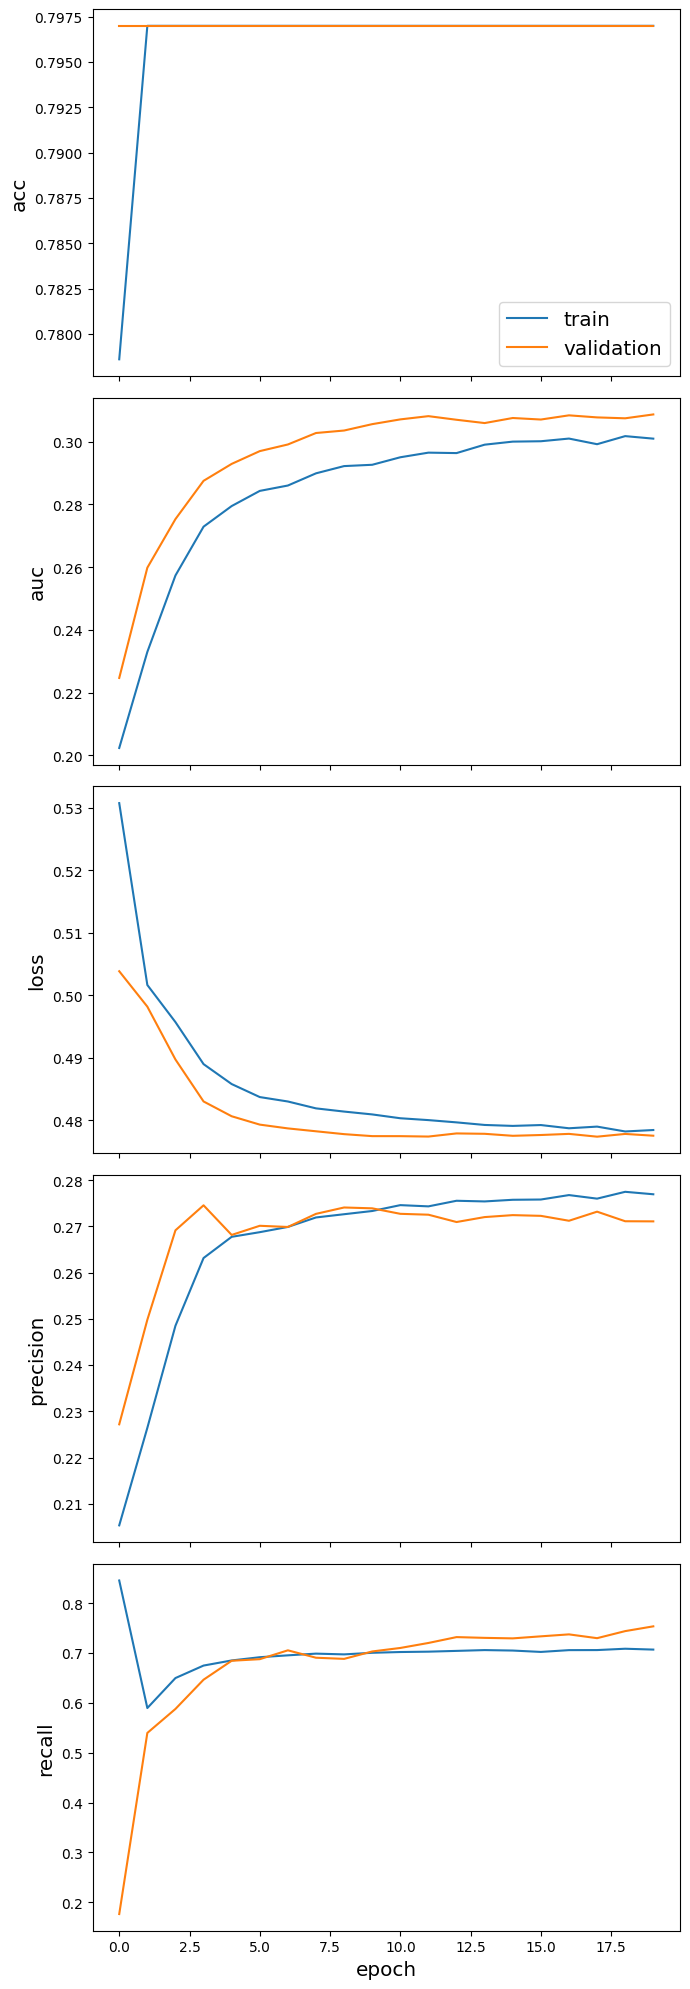

In [21]:
sg.utils.plot_history(history)

In [22]:
pd.DataFrame(history.history).to_csv(Path(setup.temp_path).joinpath('12_REPORT_fit_progress.csv'))

## Metrics

In [23]:
val_metrics = model.evaluate(val_gen)

1205/1205 [==============================] - 162s 135ms/step - loss: 0.4776 - acc: 0.7970 - auc: 0.3081 - precision: 0.2708 - recall: 0.7524


In [24]:
train_metrics = model.evaluate(train_gen)

5591/5591 [==============================] - 2553s 457ms/step - loss: 0.4734 - acc: 0.7970 - auc: 0.3071 - precision: 0.2769 - recall: 0.7385


In [25]:
metrics = pd.concat([pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in val_metrics]))),
                         pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in train_metrics])))],
                        keys=['val', 'train'])
metrics.to_csv(Path(setup.temp_path).joinpath('12_REPORT_train_metrics.pkl'), index=True)
metrics

,,loss,acc,auc,precision,recall
val,0,0.477612,0.796994,0.308133,0.270768,0.752352
train,0,0.473431,0.796989,0.307055,0.276931,0.738527
